# Risk Minimization with Overdue Balance

           ovd_days    ovd_amount      default     feature_1     feature_2  \
count  10000.000000  10000.000000  10000.00000  10000.000000  10000.000000   
mean      59.313900    542.243953      0.00990      0.495761      0.498892   
std       34.725189    263.281575      0.09901      0.286700      0.289545   
min        0.000000      0.000000      0.00000      0.000006      0.000017   
25%       29.000000    316.187446      0.00000      0.245967      0.248293   
50%       59.000000    539.157497      0.00000      0.496876      0.495843   
75%       89.000000    771.944865      0.00000      0.739443      0.752686   
max      119.000000    999.824630      1.00000      0.999789      0.999972   

          feature_3     feature_4     feature_5     feature_6     feature_7  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       0.499342      0.500178      0.501649      0.502764      0.494686   
std        0.288470      0.288659      0.286013      0.28855

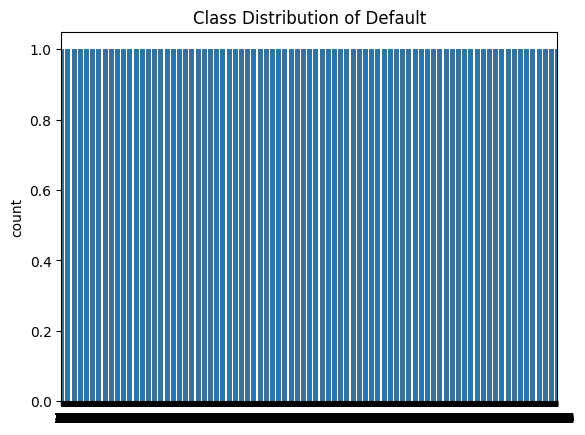


Evaluating model: MTAN
44/44 [==============================] - 0s 1ms/step
MTAN - Cross-Validation Accuracy: 0.9899
MTAN - Cross-Validation MSE: 75531.0208
47/47 [==============================] - 0s 1ms/step
Evaluating model on holdout set: MTAN
MTAN - Binary Accuracy: 0.9913
MTAN - Features Prediction MSE: 86184.3155

Evaluating model: Cross-Stitch
44/44 [==============================] - 0s 2ms/step
Cross-Stitch - Cross-Validation Accuracy: 0.9899
Cross-Stitch - Cross-Validation MSE: 70996.1580
47/47 [==============================] - 0s 1ms/step
Evaluating model on holdout set: Cross-Stitch
Cross-Stitch - Binary Accuracy: 0.9913
Cross-Stitch - Features Prediction MSE: 72867.2869

Evaluating model: MTL-DNN
44/44 [==============================] - 0s 2ms/step
MTL-DNN - Cross-Validation Accuracy: 0.9899
MTL-DNN - Cross-Validation MSE: 71554.3880
47/47 [==============================] - 0s 2ms/step
Evaluating model on holdout set: MTL-DNN
MTL-DNN - Binary Accuracy: 0.9913
MTL-DNN - F

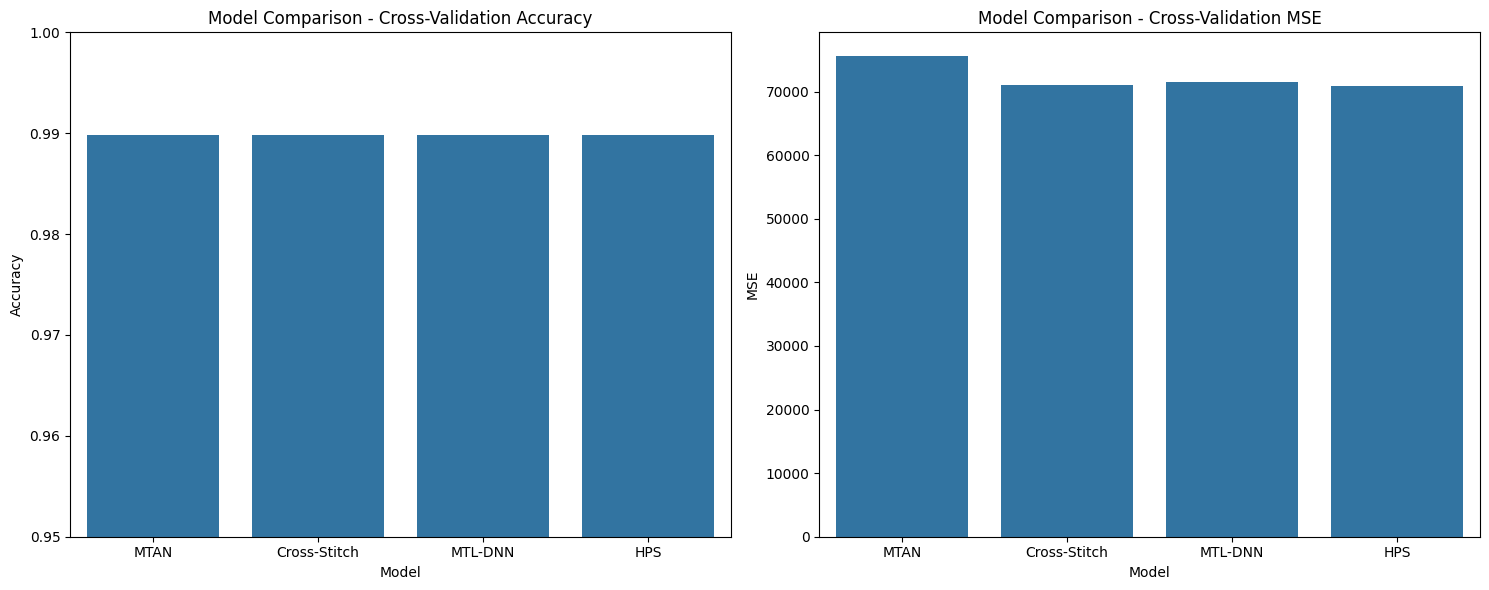

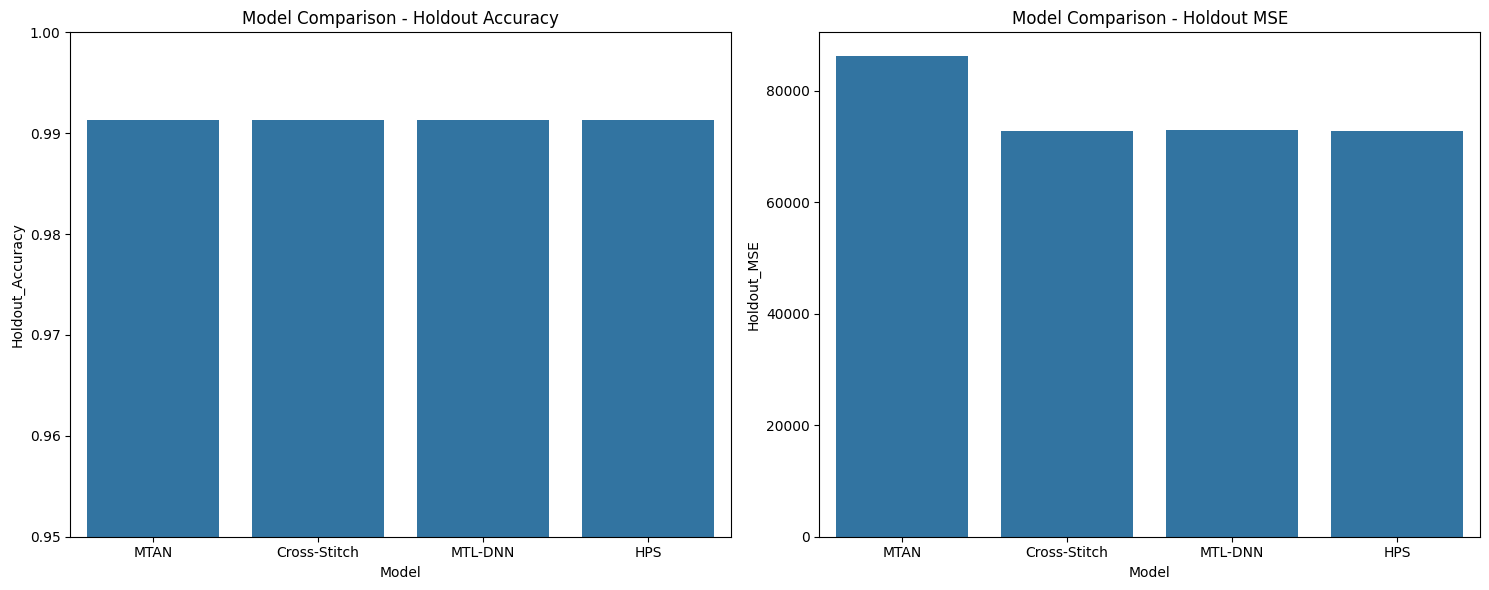

In [12]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, Attention
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic dataset
n_samples = 10000

# Generate ovd_days (overdue days)
ovd_days = np.random.randint(0, 120, size=n_samples)

# Generate overdue amount based on ovd_days (overdue)
ovd_amount = np.where(ovd_days > 0, np.random.uniform(100, 1000, size=n_samples), 0)

# Define the target variable 'default' with imbalance (less than 1% default)
default = np.where(np.random.rand(n_samples) < 0.01, 1, 0)

# Generate additional 16 features (e.g., income, age, credit score, etc.)
additional_features = {
    f'feature_{i}': np.random.uniform(0, 1, size=n_samples)
    for i in range(1, 17)
}

# Create a DataFrame
data = pd.DataFrame({
    'ovd_days': ovd_days,
    'ovd_amount': ovd_amount,
    'default': default
})

# Add additional features to the DataFrame
for feature_name, values in additional_features.items():
    data[feature_name] = values

# Data exploration and sanity check
print(data.describe())
print(data.isnull().sum())
print("Class distribution for 'default':")
print(data['default'].value_counts(normalize=True))

# Plot class imbalance
sns.countplot(data['default'])
plt.title('Class Distribution of Default')
plt.show()

# Separate features and targets
X = data.drop(columns=['ovd_amount', 'default'])
y_classification = data['default']
y_regression = data['ovd_amount']

# Split the data into training, test, and holdout sets
X_train, X_temp, y_train_class, y_temp_class, y_train_reg, y_temp_reg = train_test_split(
    X, y_classification, y_regression, test_size=0.3, random_state=42
)
X_test, X_holdout, y_test_class, y_holdout_class, y_test_reg, y_holdout_reg = train_test_split(
    X_temp, y_temp_class, y_temp_reg, test_size=0.5, random_state=42
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_holdout_scaled = scaler.transform(X_holdout)

# Define function to create model architectures
def create_model(model_type):
    input_layer = Input(shape=(X_train_scaled.shape[1],))
    shared = Dense(64, activation='relu')(input_layer)
    shared = Dropout(0.3)(shared)
    
    if model_type == 'MTAN':
        # MTAN model architecture with attention mechanism
        attention = Attention()([shared, shared])
        shared = Concatenate()([shared, attention])
        classification_branch = Dense(16, activation='relu')(shared)
        classification_output = Dense(1, activation='sigmoid', name='classification_output')(classification_branch)
        regression_branch = Dense(16, activation='relu')(shared)
        regression_output = Dense(1, activation='linear', name='regression_output')(regression_branch)
    elif model_type == 'Cross-Stitch':
        # Cross-Stitch model architecture
        cross_stitch_layer = Dense(32, activation='relu')(shared)
        classification_branch = Dense(32, activation='relu')(cross_stitch_layer)
        classification_output = Dense(1, activation='sigmoid', name='classification_output')(classification_branch)
        regression_branch = Dense(32, activation='relu')(cross_stitch_layer)
        regression_output = Dense(1, activation='linear', name='regression_output')(regression_branch)
    elif model_type == 'MTL-DNN':
        # MTL-DNN model architecture with deeper layers
        shared = Dense(128, activation='relu')(shared)
        classification_branch = Dense(64, activation='relu')(shared)
        classification_output = Dense(1, activation='sigmoid', name='classification_output')(classification_branch)
        regression_branch = Dense(64, activation='relu')(shared)
        regression_output = Dense(1, activation='linear', name='regression_output')(regression_branch)
    elif model_type == 'HPS':
        # HPS model architecture (hard parameter sharing)
        classification_branch = Dense(16, activation='relu')(shared)
        classification_output = Dense(1, activation='sigmoid', name='classification_output')(classification_branch)
        regression_branch = Dense(16, activation='relu')(shared)
        regression_output = Dense(1, activation='linear', name='regression_output')(regression_branch)
    
    model = Model(inputs=input_layer, outputs=[classification_output, regression_output])
    model.compile(
        optimizer='adam',
        loss={'classification_output': 'binary_crossentropy', 'regression_output': 'mse'},
        metrics={'classification_output': 'accuracy', 'regression_output': 'mae'}
    )
    return model

# Define model types
model_types = ['MTAN', 'Cross-Stitch', 'MTL-DNN', 'HPS']

# Perform cross-validation and evaluate models
kf = KFold(n_splits=5, shuffle=True, random_state=42)

results = []

for model_type in model_types:
    print(f"\nEvaluating model: {model_type}")
    fold_accuracies = []
    fold_mses = []
    
    for train_index, val_index in kf.split(X_train_scaled):
        X_fold_train, X_fold_val = X_train_scaled[train_index], X_train_scaled[val_index]
        y_fold_train_class, y_fold_val_class = y_train_class.iloc[train_index], y_train_class.iloc[val_index]
        y_fold_train_reg, y_fold_val_reg = y_train_reg.iloc[train_index], y_train_reg.iloc[val_index]
        
        # Create and train the model
        model = create_model(model_type)
        model.fit(
            X_fold_train,
            {'classification_output': y_fold_train_class, 'regression_output': y_fold_train_reg},
            validation_data=(X_fold_val, {'classification_output': y_fold_val_class, 'regression_output': y_fold_val_reg}),
            epochs=10,
            batch_size=32,
            verbose=0
        )
        
        # Evaluate on validation set
        val_preds = model.predict(X_fold_val)
        val_class_preds = (val_preds[0] > 0.5).astype(int).flatten()
        val_reg_preds = val_preds[1].flatten()
        
        accuracy = accuracy_score(y_fold_val_class, val_class_preds)
        mse = mean_squared_error(y_fold_val_reg, val_reg_preds)
        fold_accuracies.append(accuracy)
        fold_mses.append(mse)
    
    avg_accuracy = np.mean(fold_accuracies)
    avg_mse = np.mean(fold_mses)
    results.append({'Model': model_type, 'Accuracy': avg_accuracy, 'MSE': avg_mse})
    print(f"{model_type} - Cross-Validation Accuracy: {avg_accuracy:.4f}")
    print(f"{model_type} - Cross-Validation MSE: {avg_mse:.4f}")
    
    # Evaluate on holdout set
    holdout_preds = model.predict(X_holdout_scaled)
    holdout_class_preds = (holdout_preds[0] > 0.5).astype(int).flatten()
    holdout_reg_preds = holdout_preds[1].flatten()
    
    holdout_accuracy = accuracy_score(y_holdout_class, holdout_class_preds)
    holdout_mse = mean_squared_error(y_holdout_reg, holdout_reg_preds)
    results[-1]['Holdout_Accuracy'] = holdout_accuracy
    results[-1]['Holdout_MSE'] = holdout_mse
    print(f"Evaluating model on holdout set: {model_type}")
    print(f"{model_type} - Binary Accuracy: {holdout_accuracy:.4f}")
    print(f"{model_type} - Features Prediction MSE: {holdout_mse:.4f}")

# Convert results to DataFrame and plot for easy comparison
results_df = pd.DataFrame(results)

# Plot model comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.barplot(x='Model', y='Accuracy', data=results_df, ax=axes[0])
axes[0].set_title('Model Comparison - Cross-Validation Accuracy')
axes[0].set_ylim(0.95, 1.0)
sns.barplot(x='Model', y='MSE', data=results_df, ax=axes[1])
axes[1].set_title('Model Comparison - Cross-Validation MSE')
plt.tight_layout()
plt.show()

# Holdout set performance
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.barplot(x='Model', y='Holdout_Accuracy', data=results_df, ax=axes[0])
axes[0].set_title('Model Comparison - Holdout Accuracy')
axes[0].set_ylim(0.95, 1.0)
sns.barplot(x='Model', y='Holdout_MSE', data=results_df, ax=axes[1])
axes[1].set_title('Model Comparison - Holdout MSE')
plt.tight_layout()
plt.show()
